# Design Resources for Developers

Design Resources for Developers is a UI for Brad Traversy's curated [repository](https://github.com/bradtraversy/design-resources-for-developers) by the same name. Executing this Jupyter notebook will scrape data from a forked branch of the repository which is used to create a Django Rest Framework API. The API is then used to populate a React frontend.

## Table of Contents

- [Design Resources for Developers](#design-resources-for-developers)
  * [Table of Contents](#table-of-contents)
  * [Installation](#installation)
    + [Fork the repository](#fork-the-repository)
    + [Create a virtual environment](#create-a-virtual-environment)
    + [Install dependencies](#install-dependencies)
  + [Scrape the data](#scrape-the-data)
    + [Verify the results](#verify-the-results)
    + [Analyze and clean the data](#analyze-and-clean-the-data)
  + [Create visualizations](#create-visualizations)
  + [Create a PostgreSQL database to save the data](#create-a-postgresql-database-to-save-the-data)


### Installation


#### Fork the repository

Fork the [repository](https://github.com/bradtraversy/design-resources-for-developers). This will allow you to scrape the data from your own repository. This notebook will scrape from `https://github.com/ajhughesdev/design-resources-for-developers/`.

#### Create a virtual environment

In [1]:
!mkdir design-resources-for-developers
!cd design-resources-for-developers

!virtualenv .venv -p 3.10
!source .venv/bin/activate

created virtual environment CPython3.10.10.final.0-64 in 241ms
  creator CPython3Posix(dest=/Users/ajhughesdev/Desktop/design-resources-4-developers/backend/.venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/Users/ajhughesdev/Library/Application Support/virtualenv)
    added seed packages: pip==23.0.1, setuptools==67.4.0, wheel==0.38.4
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import platform
platform.python_version()

'3.10.10'

#### Install dependencies

In [3]:
pip install scrapy pandas psycopg2 ipython-sql python-dotenv matplotlib wordcloud==1.8.1

Note: you may need to restart the kernel to use updated packages.


### Scrape the Resources

In [4]:
import scrapy
from scrapy.crawler import CrawlerProcess

In [5]:
# defines a class named "JsonWritePipeline" that is used to write scraped data to a JSON Lines file
import json


class JsonWritePipeline(object):
  
    def open_spider(self, spider):
        self.file = open('resourceresults.jl', 'w')
    
    def close_spider(self, spider):
        self.file.close()
    
    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item

In [6]:
# defines a class named "ResourceSpider" that is used to scrape the data from the website
import logging


class ResourceSpider(scrapy.Spider):
    name = "resources"
    start_urls = [
        'https://github.com/ajhughesdev/design-resources-for-developers',
    ]
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.JsonWritePipeline': 1},
        'FEEDS': {'resourceresults.jl': {'format': 'jl', 'overwrite': True}},
    }
  
    def parse(self, response):
        for category in response.xpath('//h2'):
            category_name = category.xpath('string(.)').extract_first().strip()
            resources = []
            for resource in category.xpath('./following-sibling::table[1]//tr'):
                resource_name_elem = resource.xpath('./td[1]/a/text()')
                if not resource_name_elem:
                    continue
                resource_name = resource.xpath('./td[1]/a/text()').extract_first().strip()
                resource_link = resource.xpath('./td[1]/a/@href').extract_first().strip()
                resource_desc = resource.xpath('./td[2]/text()').extract_first().strip()
                resource_category = category_name
                resources.append({'name': resource_name, 'link': resource_link, 'description': resource_desc, 'category': resource_category})
                
            yield {'category': category_name, 'resources': resources}

In [7]:
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(ResourceSpider)
process.start()

2023-03-31 09:44:37 [scrapy.utils.log] INFO: Scrapy 2.8.0 started (bot: scrapybot)
2023-03-31 09:44:37 [scrapy.utils.log] INFO: Versions: lxml 4.9.2.0, libxml2 2.9.13, cssselect 1.2.0, parsel 1.7.0, w3lib 2.1.1, Twisted 22.10.0, Python 3.10.10 (main, Feb 16 2023, 02:49:39) [Clang 14.0.0 (clang-1400.0.29.202)], pyOpenSSL 23.1.0 (OpenSSL 3.1.0 14 Mar 2023), cryptography 40.0.1, Platform macOS-13.4-arm64-arm-64bit
2023-03-31 09:44:37 [scrapy.crawler] INFO: Overridden settings:
{'LOG_LEVEL': 30,
 'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}
2023-03-31 09:44:37 [py.warnings] WARNING: /Users/ajhughesdev/Desktop/design-resources-4-developers/.venv/lib/python3.10/site-packages/scrapy/utils/request.py:232: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' s

#### Verify the results

In [18]:
# Check the file was created
!ls resourceresults.jl

resourceresults.jl


In [19]:
# Check that data was written to the file
!tail -n 2 resourceresults.jl

{"category": "Packages 0", "resources": []}
{"category": "Footer", "resources": []}


#### Analyze and clean the results

In [20]:
import pandas as pd

# read the JSON Lines file into a Pandas DataFrame  
df = pd.read_json('resourceresults.jl', lines=True)
df

,category,resources
0,Latest commit,[]
1,Git stats,[]
2,Files,[]
3,readme.md,[]
4,Table of Contents,"[{'name': 'SVG sine waves', 'link': 'https://w..."
5,UI Graphics,"[{'name': 'SVG sine waves', 'link': 'https://w..."
6,Fonts,"[{'name': 'Google Fonts', 'link': 'https://fon..."
7,Colors,"[{'name': 'Color Brewer 2', 'link': 'https://c..."
8,Icons,"[{'name': 'Circum Icons', 'link': 'https://cir..."
9,Logos,"[{'name': 'LogoSear.ch', 'link': 'https://logo..."


In [21]:
# Remove rows with empty resources
df = df[df['resources'].map(len) > 0]

# Remove category 'Table of Contents'
df = df[df['category'] != 'Table of Contents']

# Remove GetAvataaars
df = df[df['resources'].apply(lambda x: 'GetAvataaars' not in [r['name'] for r in x])]

df.to_json('resourceresults.jl')

df.head()

,category,resources
5,UI Graphics,"[{'name': 'SVG sine waves', 'link': 'https://w..."
6,Fonts,"[{'name': 'Google Fonts', 'link': 'https://fon..."
7,Colors,"[{'name': 'Color Brewer 2', 'link': 'https://c..."
8,Icons,"[{'name': 'Circum Icons', 'link': 'https://cir..."
9,Logos,"[{'name': 'LogoSear.ch', 'link': 'https://logo..."


### Create visualizations

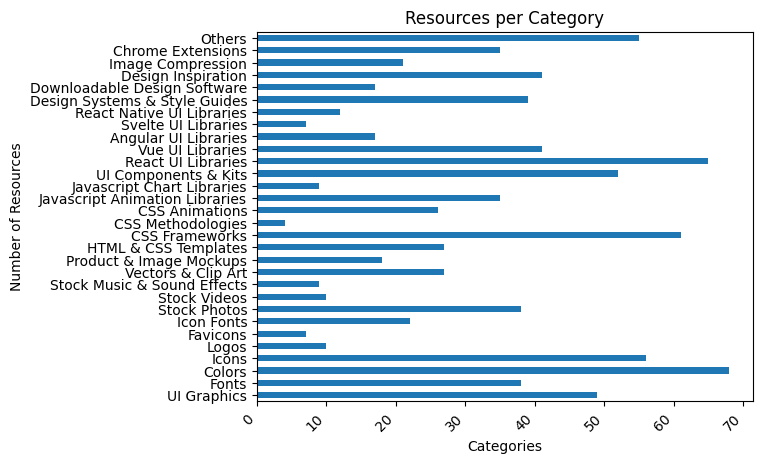

In [26]:
# Bar chart
import matplotlib.pyplot as plt

category_counts = df['resources'].apply(len)

df['resource_count'] = category_counts

def create_bar_chart(df):
    
    df = df.set_index('category')
    
    df['resource_count'].plot(kind='barh')    
    plt.xlabel('Categories')
    plt.ylabel('Number of Resources')
    plt.title('Resources per Category')
    plt.xticks(rotation=45, ha='right')
    
    plt.savefig('resources_per_category_bar.png', bbox_inches='tight')
    
    plt.show()
    
create_bar_chart(df)

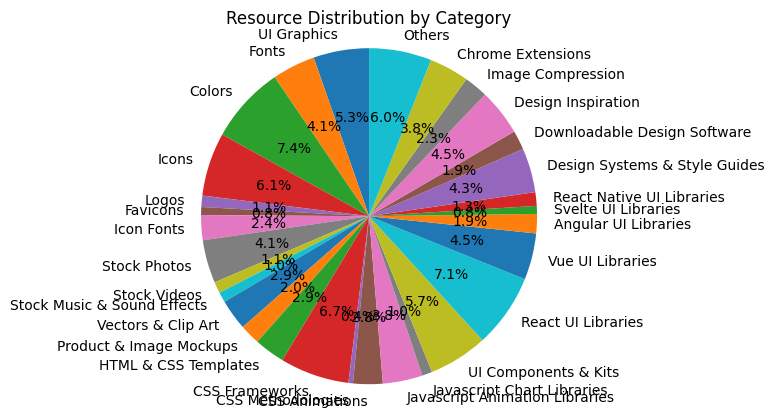

In [27]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
def create_pie_chart(df):

    plt.pie(category_counts, labels=df['category'], autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Resource Distribution by Category')
    
    plt.savefig('resources_per_category_pie.png', bbox_inches='tight')

    plt.show()

create_pie_chart(df)

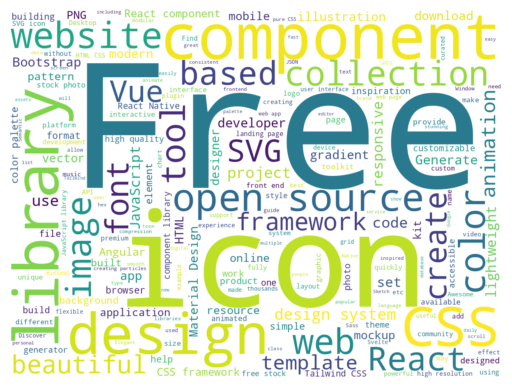

In [28]:
from wordcloud import WordCloud

def generate_wordcloud(df):
    all_descriptions = ' '.join(df['resources'].apply(lambda resources: ' '.join([resource['description'] for resource in resources])))

    wordcloud = WordCloud(width=1200, height=900, background_color='white', min_word_length=3).generate(all_descriptions)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    plt.savefig('wordcloud.png', bbox_inches='tight')
    
    plt.show()
    
generate_wordcloud(df)

### Save cleaned data to a db

Creating a database is outside the scope of this project, but if you need to download PostgreSQL, you can do so [here](https://www.postgresql.org/download/). Follow the [documentation](https://www.postgresql.org/docs/current/installation.html) to install and create a database named "resourcesdb". 

In [25]:
# Save the data to a PostgreSQL database
import psycopg2
from dotenv import load_dotenv
import os

load_dotenv()

# connect to postgresql database
conn = psycopg2.connect(database="resourcesdb", user=os.environ.get('PGUSERNAME'), password=os.environ.get('PGPASSWORD'), host="localhost", port="5432")

c = conn.cursor()

# Drop the existing tables
c.execute('DROP TABLE IF EXISTS design_resources_for_devs_resource')
c.execute('DROP TABLE IF EXISTS design_resources_for_devs_category')

# Create the new tables
c.execute('''
    CREATE TABLE IF NOT EXISTS design_resources_for_devs_category (
        id SERIAL PRIMARY KEY,
        name VARCHAR(150) UNIQUE NOT NULL
    )
''')

c.execute('''
    CREATE TABLE IF NOT EXISTS design_resources_for_devs_resource (
        id SERIAL PRIMARY KEY,
        name VARCHAR(150) NOT NULL,
        description TEXT NOT NULL,
        link VARCHAR(200) NOT NULL,
        category_id INTEGER NOT NULL REFERENCES design_resources_for_devs_category (id),
        CONSTRAINT unique_name_category UNIQUE (name, category_id)
    )
''')

conn.commit()

# Insert the data
for index, row in df.iterrows():
    c.execute("""
        INSERT INTO design_resources_for_devs_category (name)
        VALUES (%s)
        ON CONFLICT (name) DO NOTHING
    """, (row['category'],))

    c.execute("""
        SELECT id
        FROM design_resources_for_devs_category
        WHERE name = %s
    """, (row['category'],))
    category_id = c.fetchone()[0]

    for resource in row['resources']:
        c.execute("""
            INSERT INTO design_resources_for_devs_resource (name, description, link, category_id)
            VALUES (%s, %s, %s, %s)
            ON CONFLICT (name, category_id) DO NOTHING
        """, (resource['name'], resource['description'], resource['link'], category_id))

conn.commit()
conn.close()

True

TODO: Add instructions for creating a Django project and a React frontend.